**Import Data**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kc_house_data.csv to kc_house_data.csv


**Library Pendukung**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Membaca Dataset**

In [3]:
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


**Data Checking**

1. Memeriksa apakah dataset memiliki nilai kosong
2. Memeriksa tipe data
3. Memeriksa persebaran statistik data 
4. Menggambarkan visualisasi perseberan harga rumah berdasarkan luas rumah
5. Visualisasi nilai korelasi antar seluruh fitur dengan target fitur yang akan diprediksi yaitu "price"

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

3. Memeriksa persebaran statistik data 

In [5]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [6]:
data = df.drop(columns=['id','date'])
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21611.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.396095,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.128162,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


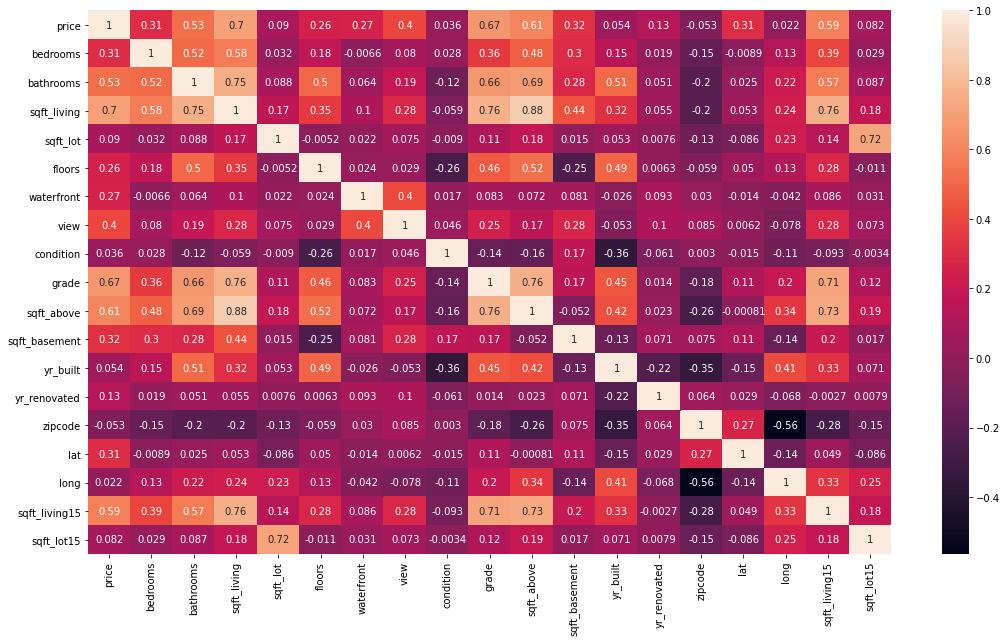

In [7]:
#data = df.drop(columns=['id','date'])
corr = data.corr()
f = plt.subplots(figsize=(18,10))
sns.heatmap(corr,annot=True)

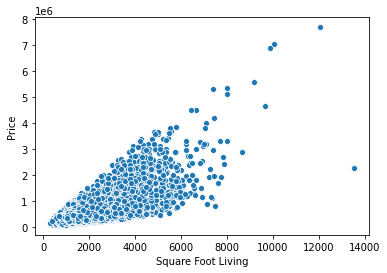

In [8]:
data1 = data[["price","sqft_living"]]
ax = sns.scatterplot(data1["sqft_living"],data1["price"])
ax.set(xlabel="Square Foot Living", ylabel="Price")
plt.show()

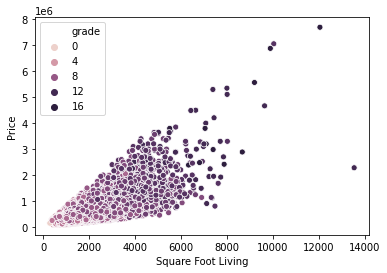

In [9]:
data3 = data[["sqft_living","grade","price"]]
ax = sns.scatterplot(data3["sqft_living"],data3["price"],data3["grade"])
ax.set(xlabel="Square Foot Living",ylabel="Price")
plt.show()

In [10]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


Dari visualisasi nilai korelasi fitur dengan target fitur "price" diatas maka dapat disimpulkan fitur dengan nilai korelasi paling tinggi (>=0.5) adalah
1. "sqft_living" = 0.71
2. "grade" = 0.65
3. "sqft_above" = 0.6
4. "sqft_living15" = 0.61
5. "bathrooms" = 0.53
Nantinya ke-5 fitur yang sudah dipilih akan diseleksi kembali agar didapatkan inputan fitur yang dapat menjadi model regresi dengan hasil maksimal 

In [11]:
data = data.drop(['bedrooms','floors','waterfront','sqft_lot','condition','yr_built','yr_renovated','zipcode','long','lat','sqft_lot15','sqft_basement','view'],axis=1)
data.head()

,price,bathrooms,sqft_living,grade,sqft_above,sqft_living15
0,221900.0,1.00,1180,7,1180.0,1340
1,538000.0,2.25,2570,7,2170.0,1690
2,180000.0,1.00,770,6,770.0,2720
3,604000.0,3.00,1960,7,1050.0,1360
4,510000.0,2.00,1680,8,1680.0,1800


**Feature Selection: RFE**

1. Menghapus nilai kosong pada fitur "sqft_living15"
2. Memisahkan 2 array array pertama berisi fitur target "price" 
3. Array kedua berisi fitur-fitur yang akan diseleksi menggunakan RFE (Recursive Feature Elimination) 

In [0]:
data = data.dropna()
array = data.values
X = array[:,1:6]
Y = array[:,0]

1. Recursive Feature Elimination (RFE) menggunakan model estimator untuk mengurutkan fitur. RFE bekerja dengan menghapus fitur secara rekursif dan membangun model dengan atribut tersisa
2. Lalu model akan mengidentifikasi fitur mana yang paling berkontribusi untuk memprediksi fitur target "price" dalam array Y
3. Jumlah fitur yang dicari diperkecil menjadi 2
4. Dengan menyeleksi fitur diharapkan dapat mengurangi overfitting, meningkatkan akurasi dan mempersingkat waktu training

In [13]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
regressor=SVR(kernel='linear',C=10,gamma='auto')
rfe = RFE(regressor,2)
fit = rfe.fit(X,Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 2
Selected Features: [ True False  True False False]
Feature Ranking: [1 2 1 4 3]


1. Dari penyeleksian diatas didapatkan 2 fitur terbaik yaitu "bathrooms" dan "grade"
2. Membuat model regressi untuk memprediksi data training dan data testing dengan fitur terpilih

In [26]:
data.head()

,price,bathrooms,sqft_living,grade,sqft_above,sqft_living15
0,221900.0,1.00,1180,7,1180.0,1340
1,538000.0,2.25,2570,7,2170.0,1690
2,180000.0,1.00,770,6,770.0,2720
3,604000.0,3.00,1960,7,1050.0,1360
4,510000.0,2.00,1680,8,1680.0,1800


In [0]:
target = data['price']

In [0]:
features = data.drop(['price','sqft_above','sqft_living','sqft_living15'], axis=1)

In [16]:
features.head()

,bathrooms,grade
0,1.00,7
1,2.25,7
2,1.00,6
3,3.00,7
4,2.00,8


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=200) 

In [0]:
regressor=SVR(kernel='linear',C=500,gamma='auto')
regressor.fit(X_train, y_train)
pred=regressor.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,pred))

**Metrics Evaluation: R-square, MSE, RMSE, MAE**

1. R-square 
2. MSE : Menghitung nilai rata-rata error dari fitur test "price" dengan nilai "price" terprediksi
3. RMSE : Sederhananya, menghitung akar dari nilai MSE
4. MAE : Menghitung seberapa dekat prediksi dari nilai sebenarnya (jumlah rata-rata perbedaan antara "price" pada data test dengan "price" terprediksi

In [19]:
print(r2_score(y_test, pred))

0.3809324658947637


In [20]:
print(mean_squared_error(y_test, pred))

81236557501.81645


In [21]:
print(rmse)

285020.2755977484


In [23]:
print(mean_absolute_error(y_test,pred))

165336.0250777826


Evaluation on Data Train

In [0]:
regressor=SVR(kernel='linear',C=500,gamma='auto')
regressor.fit(X_train, y_train)
pred=regressor.predict(X_train)
rmse = sqrt(mean_squared_error(y_train,pred))

In [25]:
print(r2_score(y_train, pred))

0.41084267825117804
